![](img/330-banner.png)

# Bonus: A high-level quick introduction to LLMs

UBC 2022-23

Instructor: Varada Kolhatkar

### Imports

In [1]:
import sys
from collections import defaultdict
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append(os.path.join(os.path.abspath("."), "code"))
from plotting_functions import *

pd.set_option("display.max_colwidth", 0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### What is a language model? 

How would you complete the sentence below? 

I am ___

<br><br><br><br>

A language model computes the probability distribution over sequences (of words or characters). Intuitively, this probability tells us how "good" or plausible a sequence of words is. 




![](img/voice-assistant-ex.png)

![](img/smart-compose.gif)

Humans aren't good at providing calibrated probabilities for arbitrary texts. What if we ask this to billions of people and calculate probabilities based on the frequencies of words?

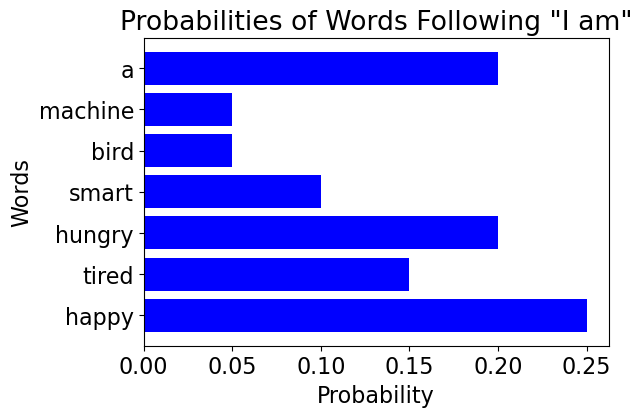

In [2]:
# Words to display on the y-axis
words = ["happy", "tired", "hungry", "smart", "bird", "machine", "a"]

# Hypothetical probabilities for each word following "I am"
probabilities = [0.25, 0.15, 0.20, 0.10, 0.05, 0.05, 0.20]
show_made_up_probs(words, probabilities)

### A simple model of language 

- Calculate the co-occurrence frequencies and probabilities based on these frequencies
- Predict the next word based on these probabilities

![](img/Markov-bigram-probs.png)

### Long-distance dependencies 
What are some reasonable predictions for the next word in the sequence? 

> I am studying law at the University of British Columbia Point Grey campus in Vancouver because I want to work as a ___

Markov model is unable to capture such long-distance dependencies in language. 

Enter attention and transformer models! All current LLMs are based on transformer-based architectures under the hood. 


![](img/baby-chatGPT-ex.png)

- The most important component of transformer models is self-attention which is inspired by the idea of human attention. 
- The attention weights are learned during the training process. They reflect the relative - importance of each word with respect to the task at hand.
- ChatGPT fine tunes next word prediction on Q&A task (instruction tuning and RLHF) 
- The context or the "prompt" we provide guides the prediction.

<br><br><br><br>

## [🤗 Transformers library](https://huggingface.co/docs/transformers/index)
- The Hugging Face Transformers library is a popular open-source Python library for working with transformer models.
- It provides a wide range of pre-trained transformer models which have achieved top performance in many state-of-the-art NLP tasks.
- It provides 
    - an easy-to-use API that allows using these pre-trained models off-the-shelf for tasks such as text classification, question answering, named entity recognition, or machine translation.  
    - an easy-to-use API that allows developers to fine-tune pre-trained transformer models on their own NLP tasks.  
- It also includes utilities for tokenization, model inference, and training and other useful features for model visualization, model comparison, and model sharing via the Hugging Face model hub.  
- It supports various deep learning frameworks such as PyTorch and TensorFlow and provides a unified inferface to working with transformer models across these frameworks. 
- Excellent documentation and very useful tool for NLP practioners and researchers

### Installation 
First, install the library if it's not already in your course environment. On the command line, activate the course environment and install the library. [Here](https://huggingface.co/docs/transformers/installation) you will find installation instructions. 

`pip install transformers`

### Using pre-trained transformer models  

- Let's try sentiment analysis with pre-trained models. 
- An easiest way to get started with using pre-trained transformer models is using [pipelines](https://huggingface.co/docs/transformers/pipeline_tutorial) which abstracts many things away from the user. 

In [3]:
from transformers import pipeline

input_text = "CPSC330-2023W1 students are the best!"
sentiment_classifier = pipeline("sentiment-analysis")
pd.DataFrame(sentiment_classifier(input_text))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


,label,score
0,POSITIVE,0.999864


Right now it's using the default pre-trained model. You can use a model is more suitable for your specific language or data. 

You can also pass a list of documents to the pipeline. 

In [14]:
sentiment_classifier = pipeline("sentiment-analysis")
input_text = ["CPSC330-2023W1 students are the best!", "I am sad that this is the last lecture of the course."]
pd.DataFrame(sentiment_classifier(input_text))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


,label,score
0,POSITIVE,0.999864
1,NEGATIVE,0.999641


You can also explicitly specify the pre-trained model you want to use specific to your data. For example, if you want to do sentiment analysis on Twitter data, it's better to use a model trained on twitter data. 
There are more than 1000 sentiment analysis models publicly available on [the Hub](https://huggingface.co/models) and integrating them with Python just a few lines of code. Let's just go with one of the most commonly used model for sentiment analysis.  

In [5]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_classifier = pipeline("sentiment-analysis", model=model_name)
pd.DataFrame(sentiment_classifier(input_text))

,label,score
0,POSITIVE,0.999864
1,NEGATIVE,0.999641


### Prompts

- Up until recently, language models were only a component of a large system such as speech recognition system or machine translation system.
- Now they are becoming more capable of being a standalone system. 
- Language models are capable of conditional generation. So they are capable of generating completion given a prompt.  
$$\text{prompt} \rightarrow \text{completion}$$
- This simple interface opens up lets us use language models for a variety of tasks by just changing the prompt. 
- Let's try a couple of prompts with the T5 encoder decoder language model. 
- The following examples are based on the documentation [here](https://huggingface.co/docs/transformers/model_doc/t5).

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

In [7]:
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = AutoModelWithLMHead.from_pretrained('t5-base', return_dict=True)

/Users/kvarada/miniconda3/envs/cpsc330/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/Users/kvarada/miniconda3/envs/cpsc330/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future versio

In [8]:
sequence = ('''
           A transformer is a deep learning model that adopts the mechanism of self-attention, 
           differentially weighting the significance of each part of the input data. 
           It is used primarily in the fields of natural language processing (NLP) and computer vision (CV).
           Like recurrent neural networks (RNNs), transformers are designed to process sequential input data, 
           such as natural language, with applications towards tasks such as translation and text summarization. 
           However, unlike RNNs, transformers process the entire input all at once. 
           The attention mechanism provides context for any position in the input sequence. 
           For example, if the input data is a natural language sentence, 
           the transformer does not have to process one word at a time. 
           This allows for more parallelization than RNNs and therefore reduces training times.
           
           Transformers were introduced in 2017 by a team at Google Brain and are increasingly the model of choice 
           for NLP problems, replacing RNN models such as long short-term memory (LSTM). 
           The additional training parallelization allows training on larger datasets. 
           This led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) 
           and GPT (Generative Pre-trained Transformer), which were trained with large language datasets, 
           such as the Wikipedia Corpus and Common Crawl, and can be fine-tuned for specific tasks. 
           
           Before transformers, most state-of-the-art NLP systems relied on gated RNNs, 
           such as LSTMs and gated recurrent units (GRUs), with added attention mechanisms. 
           Transformers also make use of attention mechanisms but, unlike RNNs, do not have a recurrent structure. 
           This means that provided with enough training data, attention mechanisms alone can match the performance 
           of RNNs with attention.
           
           Gated RNNs process tokens sequentially, maintaining a state vector that contains 
           a representation of the data seen prior to the current token. To process the 
           nth token, the model combines the state representing the sentence up to token n-1 with the information 
           of the new token to create a new state, representing the sentence up to token n. 
           Theoretically, the information from one token can propagate arbitrarily far down the sequence, 
           if at every point the state continues to encode contextual information about the token. 
           In practice this mechanism is flawed: the vanishing gradient problem leaves the model's state at 
           the end of a long sentence without precise, extractable information about preceding tokens. 
           The dependency of token computations on the results of previous token computations also makes it hard 
           to parallelize computation on modern deep-learning hardware. This can make the training of RNNs inefficient.
           
           These problems were addressed by attention mechanisms. Attention mechanisms let a model draw 
           from the state at any preceding point along the sequence. The attention layer can access 
           all previous states and weigh them according to a learned measure of relevance, providing 
           relevant information about far-away tokens.
           
           A clear example of the value of attention is in language translation, where context is essential 
           to assign the meaning of a word in a sentence. In an English-to-French translation system, 
           the first word of the French output most probably depends heavily on the first few words of the English input. 
           However, in a classic LSTM model, in order to produce the first word of the French output, the model 
           is given only the state vector after processing the last English word. Theoretically, this vector can encode 
           information about the whole English sentence, giving the model all the necessary knowledge. 
           In practice, this information is often poorly preserved by the LSTM. 
           An attention mechanism can be added to address this problem: the decoder is given access to the state vectors of every English input word, 
           not just the last, and can learn attention weights that dictate how much to attend to each English input state vector.
            ''')

In [9]:
prompt = "summarize: "
inputs = tokenizer.encode(prompt + sequence, return_tensors="pt", max_length=512, truncation=True)

In [10]:
summary_ids = model.generate(inputs, max_length=150, min_length=80, length_penalty=5., num_beams=2)
summary_ids

tensor([[    0,     3,     9, 19903,    19,     3,     9,  1659,  1036,   825,
            24,  4693,     7,     8,  8557,    13,  1044,    18, 25615,     3,
             5,  9770,     3,    60, 14907, 24228,  5275,    41, 14151,   567,
             7,   201, 19903,     7,   433,     8,  1297,  3785,    66,    44,
           728,     3,     5,     8,  1388,  8557,   795,  2625,    21,   136,
          1102,    16,     8,  3785,  5932,     3,     5, 19903,     7,   130,
          3665,    16,  1233,    57,     3,     9,   372,    44, 10283,  2241,
             3,     5,     8,  1388,  8557,    19,  1126,    12,    24,    13,
             3,     9,     3,    60, 14907, 24228,  1229,    41, 14151,   567,
            61,     1]])

In [11]:
tokenizer.decode(summary_ids[0])

'<pad> a transformer is a deep learning model that adopts the mechanism of self-attention. unlike recurrent neural networks (RNNs), transformers process the entire input all at once. the attention mechanism provides context for any position in the input sequence. transformers were introduced in 2017 by a team at google brain. the attention mechanism is similar to that of a recurrent neural network (RNN)</s>'

<br><br>

Let's try translation with the same model. 

In [12]:
input_ids = tokenizer("translate English to German: The house is wonderful.", return_tensors="pt").input_ids

labels = tokenizer("Das Haus ist wunderbar.", return_tensors="pt").input_ids
labels

tensor([[  644,  4598,   229, 19250,     5,     1]])

In [13]:
tokenizer.decode(labels[0])

'Das Haus ist wunderbar.</s>'

<br><br><br><br>

### Increase in size of language models 
- The model sizes have increased by an order of 500x over the last 4 years. 

![](img/model-sizes.png)

[Source](https://stanford-cs324.github.io/winter2022/lectures/introduction/)

### Harms of large language models 

While these models are super powerful and useful, be mindful of the harms caused by these models. Some of the harms as summarized [here](https://stanford-cs324.github.io/winter2022/lectures/harms-1/) are: 

- performance disparties
- social biases and stereotypes
- toxicity
- misinformation
- security and privacy risks
- copyright and legal protections
- environmental impact
- centralization of power

